In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
# Question 1: Physics-Informed Neural Networks for Cardiac Activation Times
# File: pinn_cardiac_activation.py

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import qmc
from sklearn.metrics import mean_squared_error
import seaborn as sns

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

class PINN(nn.Module):
    """Physics-Informed Neural Network for cardiac activation times"""
    
    def __init__(self, input_dim=2, hidden_dim=50, output_dim=1, num_layers=4):
        super(PINN, self).__init__()
        
        layers = []
        layers.append(nn.Linear(input_dim, hidden_dim))
        layers.append(nn.Tanh())
        
        for _ in range(num_layers - 2):
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.Tanh())
        
        layers.append(nn.Linear(hidden_dim, output_dim))
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.network(x)

def generate_synthetic_data(n_points=1000):
    """Generate synthetic cardiac activation data"""
    # Create a grid of points
    x = np.linspace(0, 2, int(np.sqrt(n_points)))
    y = np.linspace(0, 2, int(np.sqrt(n_points)))
    X, Y = np.meshgrid(x, y)
    
    # Flatten for computation
    x_flat = X.flatten()
    y_flat = Y.flatten()
    
    # Compute activation times T(x,y)
    dist1 = np.sqrt(x_flat**2 + y_flat**2)
    dist2 = np.sqrt((x_flat - 1)**2 + (y_flat - 1)**2)
    T = np.minimum(dist1, 0.7 * dist2)
    
    return x_flat, y_flat, T, X, Y

def compute_velocity(x, y):
    """Compute conduction velocity V(x,y)"""
    dist1 = np.sqrt(x**2 + y**2)
    dist2 = np.sqrt((x - 1)**2 + (y - 1)**2)
    
    V = np.where(dist1 < 0.7 * dist2, 1.0, 1.0/0.7)
    return V

def latin_hypercube_sampling(n_samples, bounds=[[0, 2], [0, 2]]):
    """Generate sparse training samples using Latin Hypercube Sampling"""
    sampler = qmc.LatinHypercube(d=2, seed=42)
    samples = sampler.random(n=n_samples)
    
    # Scale to bounds
    x_samples = samples[:, 0] * (bounds[0][1] - bounds[0][0]) + bounds[0][0]
    y_samples = samples[:, 1] * (bounds[1][1] - bounds[1][0]) + bounds[1][0]
    
    return x_samples, y_samples

def compute_physics_loss(model, x, y, V):
    """Compute physics-informed loss (Eikonal residual)"""
    x_tensor = torch.tensor(x, dtype=torch.float32, requires_grad=True)
    y_tensor = torch.tensor(y, dtype=torch.float32, requires_grad=True)
    V_tensor = torch.tensor(V, dtype=torch.float32)
    
    # Stack inputs
    inputs = torch.stack([x_tensor, y_tensor], dim=1)
    
    # Forward pass
    T_pred = model(inputs)
    
    # Compute gradients
    grad_T = torch.autograd.grad(
        outputs=T_pred, 
        inputs=[x_tensor, y_tensor],
        grad_outputs=torch.ones_like(T_pred),
        create_graph=True,
        retain_graph=True
    )
    
    # Compute gradient magnitude
    grad_magnitude = torch.sqrt(grad_T[0]**2 + grad_T[1]**2)
    
    # Eikonal residual: V * ||∇T|| - 1 = 0
    residual = V_tensor * grad_magnitude - 1.0
    
    return torch.mean(residual**2)

def train_model(model, x_train, y_train, T_train, is_pinn=True, epochs=5000, lr=0.001):
    """Train the neural network model"""
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)
    
    # Convert to tensors
    x_tensor = torch.tensor(x_train, dtype=torch.float32)
    y_tensor = torch.tensor(y_train, dtype=torch.float32)
    T_tensor = torch.tensor(T_train, dtype=torch.float32).unsqueeze(1)
    
    inputs = torch.stack([x_tensor, y_tensor], dim=1)
    
    # Compute velocity if PINN
    if is_pinn:
        V_train = compute_velocity(x_train, y_train)
    
    losses = []
    physics_losses = []
    
    for epoch in range(epochs):
        optimizer.zero_grad()
        
        # Data loss
        T_pred = model(inputs)
        data_loss = nn.MSELoss()(T_pred, T_tensor)
        
        total_loss = data_loss
        
        if is_pinn:
            # Physics loss
            physics_loss = compute_physics_loss(model, x_train, y_train, V_train)
            total_loss = data_loss + 0.1 * physics_loss  # Weight physics loss
            physics_losses.append(physics_loss.item())
        
        total_loss.backward()
        optimizer.step()
        scheduler.step()
        
        losses.append(total_loss.item())
        
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {total_loss.item():.6f}")
    
    return losses, physics_losses if is_pinn else []

def evaluate_model(model, x_test, y_test, T_test):
    """Evaluate model performance"""
    model.eval()
    with torch.no_grad():
        x_tensor = torch.tensor(x_test, dtype=torch.float32)
        y_tensor = torch.tensor(y_test, dtype=torch.float32)
        inputs = torch.stack([x_tensor, y_tensor], dim=1)
        
        T_pred = model(inputs).numpy().flatten()
    
    rmse = np.sqrt(mean_squared_error(T_test, T_pred))
    return T_pred, rmse

def plot_results(X, Y, T_true, T_pred1, T_pred2, model1_name, model2_name):
    """Plot comparison results"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Reshape predictions for plotting
    T_true_grid = T_true.reshape(X.shape)
    T_pred1_grid = T_pred1.reshape(X.shape)
    T_pred2_grid = T_pred2.reshape(X.shape)
    
    # Ground truth
    im1 = axes[0, 0].contourf(X, Y, T_true_grid, levels=20, cmap='viridis')
    axes[0, 0].set_title('Ground Truth')
    axes[0, 0].set_xlabel('x')
    axes[0, 0].set_ylabel('y')
    plt.colorbar(im1, ax=axes[0, 0])
    
    # Model 1 prediction
    im2 = axes[0, 1].contourf(X, Y, T_pred1_grid, levels=20, cmap='viridis')
    axes[0, 1].set_title(f'{model1_name} Prediction')
    axes[0, 1].set_xlabel('x')
    axes[0, 1].set_ylabel('y')
    plt.colorbar(im2, ax=axes[0, 1])
    
    # Model 2 prediction
    im3 = axes[0, 2].contourf(X, Y, T_pred2_grid, levels=20, cmap='viridis')
    axes[0, 2].set_title(f'{model2_name} Prediction')
    axes[0, 2].set_xlabel('x')
    axes[0, 2].set_ylabel('y')
    plt.colorbar(im3, ax=axes[0, 2])
    
    # Error plots
    error1 = np.abs(T_true_grid - T_pred1_grid)
    error2 = np.abs(T_true_grid - T_pred2_grid)
    
    im4 = axes[1, 0].contourf(X, Y, error1, levels=20, cmap='Reds')
    axes[1, 0].set_title(f'{model1_name} Error')
    axes[1, 0].set_xlabel('x')
    axes[1, 0].set_ylabel('y')
    plt.colorbar(im4, ax=axes[1, 0])
    
    im5 = axes[1, 1].contourf(X, Y, error2, levels=20, cmap='Reds')
    axes[1, 1].set_title(f'{model2_name} Error')
    axes[1, 1].set_xlabel('x')
    axes[1, 1].set_ylabel('y')
    plt.colorbar(im5, ax=axes[1, 1])
    
    # Error comparison
    axes[1, 2].plot(T_true.flatten(), T_pred1.flatten(), 'o', alpha=0.5, label=model1_name)
    axes[1, 2].plot(T_true.flatten(), T_pred2.flatten(), 's', alpha=0.5, label=model2_name)
    axes[1, 2].plot([T_true.min(), T_true.max()], [T_true.min(), T_true.max()], 'k--', label='Perfect')
    axes[1, 2].set_xlabel('True Values')
    axes[1, 2].set_ylabel('Predicted Values')
    axes[1, 2].set_title('Prediction vs Truth')
    axes[1, 2].legend()
    
    plt.tight_layout()
    plt.savefig('pinn_results.png', dpi=300, bbox_inches='tight')
    plt.show()


Physics-Informed Neural Networks for Cardiac Activation Times
Part A: Generating synthetic data...
Training samples: 30
Test samples: 10000

Part B: Training models...
Training Model 1: Data-driven NN...
Epoch 0, Loss: 0.233726
Epoch 500, Loss: 0.000544
Epoch 1000, Loss: 0.000147
Epoch 1500, Loss: 0.000048
Epoch 2000, Loss: 0.000031
Epoch 2500, Loss: 0.000020
Training Model 2: Physics-informed NN...
Epoch 0, Loss: 0.168455
Epoch 500, Loss: 0.001819
Epoch 1000, Loss: 0.000508
Epoch 1500, Loss: 0.000315
Epoch 2000, Loss: 0.000584
Epoch 2500, Loss: 0.000135

Part C: Evaluating models...
Model 1 (Data-driven) RMSE: 0.046361
Model 2 (PINN) RMSE: 0.031876


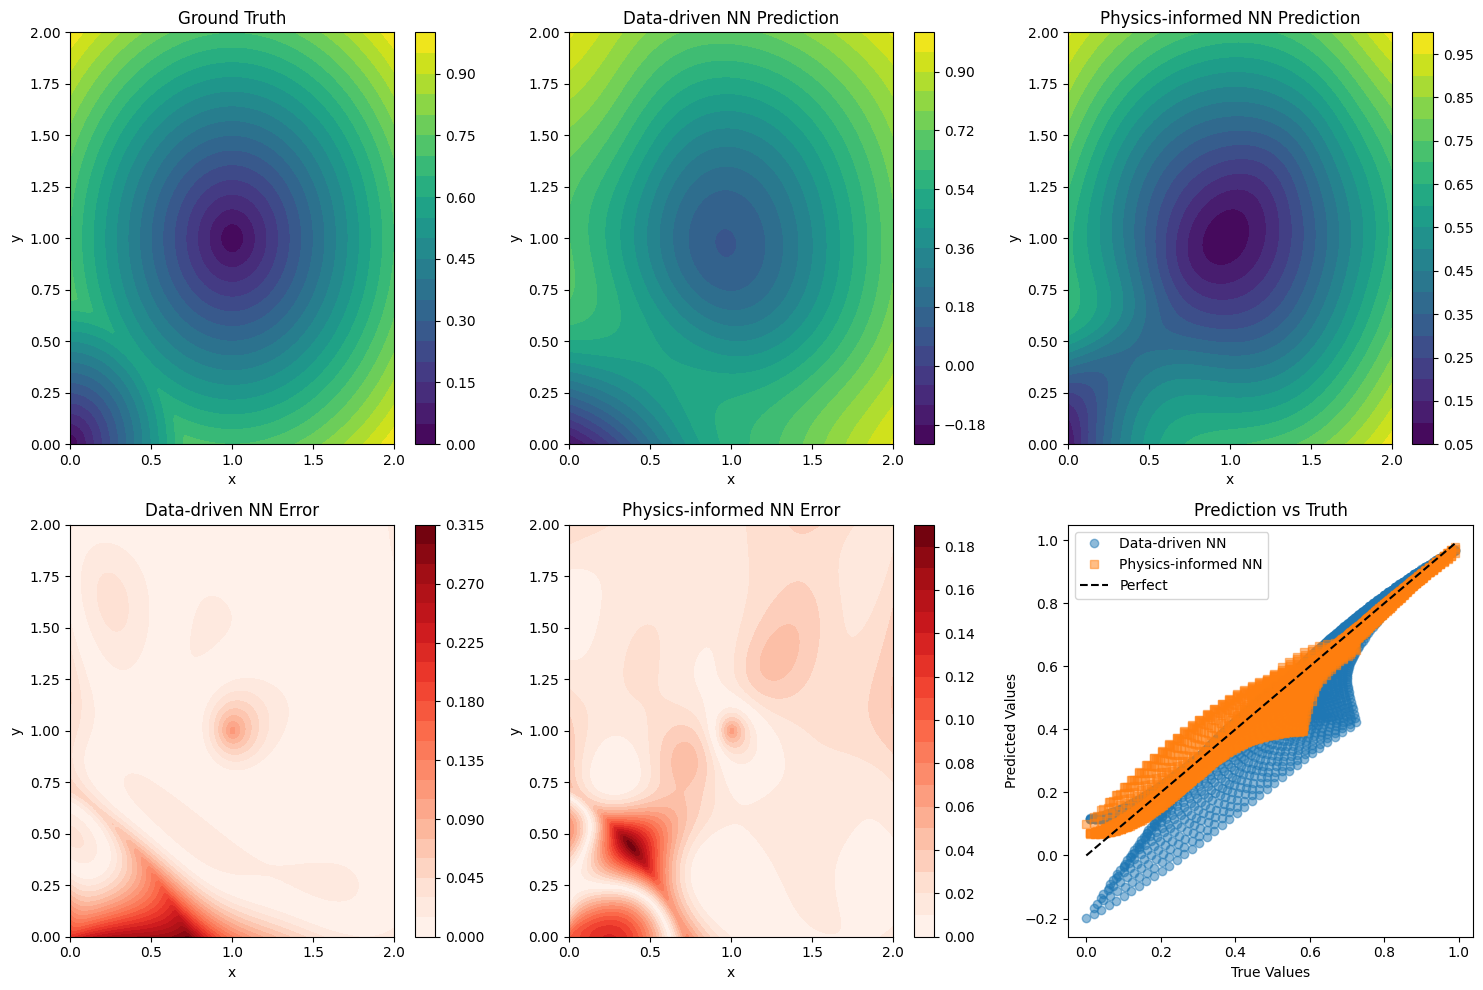

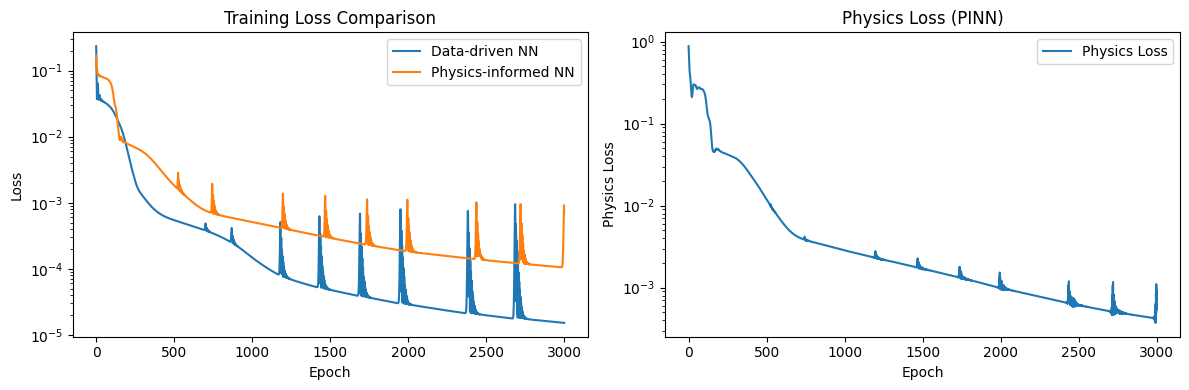


Summary:
Data-driven NN RMSE: 0.046361
Physics-informed NN RMSE: 0.031876
Improvement: 31.25%


In [2]:

def main():
    """Main execution function"""
    print("Physics-Informed Neural Networks for Cardiac Activation Times")
    print("=" * 60)
    
    # Part A: Generate data
    print("Part A: Generating synthetic data...")
    x_full, y_full, T_full, X, Y = generate_synthetic_data(n_points=10000)
    
    # Generate sparse training samples
    x_train, y_train = latin_hypercube_sampling(n_samples=30)
    
    # Compute true activation times for training points
    dist1_train = np.sqrt(x_train**2 + y_train**2)
    dist2_train = np.sqrt((x_train - 1)**2 + (y_train - 1)**2)
    T_train = np.minimum(dist1_train, 0.7 * dist2_train)
    
    print(f"Training samples: {len(x_train)}")
    print(f"Test samples: {len(x_full)}")
    
    # Part B: Build and train models
    print("\nPart B: Training models...")
    
    # Model 1: Data-driven neural network
    print("Training Model 1: Data-driven NN...")
    model1 = PINN(input_dim=2, hidden_dim=50, output_dim=1, num_layers=4)
    losses1, _ = train_model(model1, x_train, y_train, T_train, is_pinn=False, epochs=3000)
    
    # Model 2: Physics-informed neural network
    print("Training Model 2: Physics-informed NN...")
    model2 = PINN(input_dim=2, hidden_dim=50, output_dim=1, num_layers=4)
    losses2, physics_losses2 = train_model(model2, x_train, y_train, T_train, is_pinn=True, epochs=3000)
    
    # Part C: Evaluation and comparison
    print("\nPart C: Evaluating models...")
    
    # Evaluate both models
    T_pred1, rmse1 = evaluate_model(model1, x_full, y_full, T_full)
    T_pred2, rmse2 = evaluate_model(model2, x_full, y_full, T_full)
    
    print(f"Model 1 (Data-driven) RMSE: {rmse1:.6f}")
    print(f"Model 2 (PINN) RMSE: {rmse2:.6f}")
    
    # Plot results
    plot_results(X, Y, T_full, T_pred1, T_pred2, "Data-driven NN", "Physics-informed NN")
    
    # Plot training losses
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(losses1, label='Data-driven NN')
    plt.plot(losses2, label='Physics-informed NN')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Comparison')
    plt.legend()
    plt.yscale('log')
    
    if physics_losses2:
        plt.subplot(1, 2, 2)
        plt.plot(physics_losses2, label='Physics Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Physics Loss')
        plt.title('Physics Loss (PINN)')
        plt.legend()
        plt.yscale('log')
    
    plt.tight_layout()
    plt.savefig('training_losses.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Summary
    print("\nSummary:")
    print(f"Data-driven NN RMSE: {rmse1:.6f}")
    print(f"Physics-informed NN RMSE: {rmse2:.6f}")
    print(f"Improvement: {((rmse1 - rmse2) / rmse1 * 100):.2f}%")

if __name__ == "__main__":
    main()